Brain states transitions in response to working memory training
==================================================================

Analyses performed by Karolina Finc & Justyna Kuk, 
*Centre for Modern interdisciplinary Technologies, Nicolaus Copernicus University in Toruń*

Last edited: 08-07-2019

--------------

The goal of this analysis is to examine the effects of working memory training on *time-resolved brain state dynamics* examined in the trained task and the resting-state. Does working memory training affects brain state distribution in the task? 

We used unsupervised machine learning approach to cluster dual n-back and resting-state fMRI time-series into discrete brain states (see Chen et al., 2015; Cornblath et al., 2018). We hypothesize that:
- The brain states fluctuation will differ after working memory training especially in the states related to default mode and frontoparietal systems activity. 
- Training-related changes in brain states dynamics will be more visible during the trained task than the resting state.
- Individual characteristics of brain states fluctuations will be associated to individual behavioral differences in training progress.


Step 1: Timeseries preparation
----------

Prior to running clustering the time-series into discrete brain stets, all timeseries were concatenated into large $N \times P$ array containing $N$ observation and $P$ features. The length of $N$ was equal to 227040 as a result of concatenating 4 sessions of dual n-back data (340 time-points) and resting state data (305 time-points) of 44 subjects. The length of $P$ was equal 400 and represented the mean signal extracted from each brain areas of Schaefer et al. (2018) brain parcellation.

By this procedure we ensured the correspondence of brain states labels across subjects, sessions and tasks.


In [1]:
import pandas as pd
import numpy as np

# Selecting subjects for analysis
groups = pd.read_csv('data/behavioral/group_assignment.csv')

dualnback_motion = ['sub-13', 'sub-21', 'sub-23'] # higly motion subjects in one of four sessions
rest_motion = ['sub-21', 'sub-46', 'sub-47'] # higly motion subjects in one of four sessions / missing data(20-44)
rest_missing = ['sub-20', 'sub-44']

exclude = np.unique(dualnback_motion + rest_motion + rest_missing)
print(f'Subjects to exclude due to motion or missing data: {exclude}')

groups['included'] = ((groups.group == 'Experimental') | (groups.group == 'Control')) & ~groups['sub'].isin(exclude)
groups_clean = groups[groups['included'].values].reset_index()

n_sub = groups.included.values.sum()
print(f'Number of subjects included in analyses: {n_sub}')

Subjects to exclude due to motion or missing data: ['sub-13' 'sub-20' 'sub-21' 'sub-23' 'sub-44' 'sub-46' 'sub-47']
Number of subjects included in analyses: 39


In [2]:
import numpy as np

# Loading time-series data
ts_dualnback_raw = np.load("timeseries_schaefer400_dualnback.npy")
ts_rest_raw = np.load("timeseries_schaefer400_rest.npy")

ts_dualnback = ts_dualnback_raw[groups['included'].values]
ts_rest = ts_rest_raw[groups['included'].values]

print(f'Original dualnback data shape: {ts_dualnback.shape}')
print(f'Original dualnback data shape: {ts_rest.shape}')

Original dualnback data shape: (39, 4, 340, 400)
Original dualnback data shape: (39, 4, 305, 400)


In [3]:
# Concatenating time-series
n_ses = ts_dualnback.shape[1]
n_rois = ts_dualnback.shape[3]

cts_dualnback = ts_dualnback.reshape(n_sub*n_ses*ts_dualnback.shape[2], n_rois)     #all 46 subcjects in one vector
cts_rest = ts_rest.reshape(n_sub*n_ses*ts_rest.shape[2], n_rois)

# Concatenating task and rest
cts_all = np.zeros((cts_dualnback.shape[0] + cts_rest.shape[0] , n_rois))
cts_all[0:cts_dualnback.shape[0],:] = cts_dualnback 
cts_all[cts_dualnback.shape[0]:, :] = cts_rest

print(f'Shape of dualnback timeseries: {cts_dualnback.shape}')
print(f'Shape of rest timeseries: {cts_rest.shape}')
print(f'Shape of all timeseries: {cts_all.shape}')

Shape of dualnback timeseries: (53040, 400)
Shape of rest timeseries: (47580, 400)
Shape of all timeseries: (100620, 400)


Step 2: Clustering the timeseries into brain states
----------------------

To discover main brain states existing in time-series we performed 500 repetitions of $k$-means clustering from $k$ = 2 to $k$ = 18 using Euclidean distance as a measure of similarity. 

In [94]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

# max_k = 18
# brain_states = np.zeros((max_k-1,cts_all.shape[0]))
# silhouette = np.zeros((max_k-1))
# #TODO: check sklearn.cluster.MiniBatchKMeans

# for k in range(max_k-1):
#     print(f'Clustering for k = {k+2}')
#     kmeans = KMeans(n_clusters=k+2, n_init=10, random_state=1234, n_jobs=2).fit(cts_all) # Change to 500 later
#     kmeans_predict = kmeans.fit_predict(cts_all)
#     brain_states[k,:] = kmeans.labels_
#     silhouette[k] = silhouette_score(cts_all, kmeans_predict)
    
# np.save("brain_states_power_all.npy", brain_states)
# np.save("silhouette_score_power_all.npy", silhouette)

Step 3: Selecting k size based on silhouette score and absent states
-------------------------------------------------------------------------
To identify the optimal number of clusters we use silhouette score.

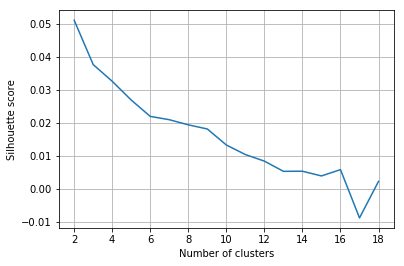

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

silhouette = np.load('silhouette_score_schaefer_all.npy')

# Plotting Silhouette score
plt.plot(np.arange(2,19), silhouette)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [5]:
import numpy as np

brain_states = np.load('brain_states_schaefer_all.npy')

bs_dualnback = brain_states[:, :cts_dualnback.shape[0]]
bs_rest = brain_states[:, cts_dualnback.shape[0]:]

sub_ses_bs_dualnback = bs_dualnback.reshape(brain_states.shape[0], n_sub, n_ses,ts_dualnback.shape[2])
sub_ses_bs_rest = bs_rest.reshape(brain_states.shape[0], n_sub, n_ses, ts_rest.shape[2])

print(sub_ses_bs_dualnback.shape)
print(sub_ses_bs_rest.shape)

(17, 39, 4, 340)
(17, 39, 4, 305)


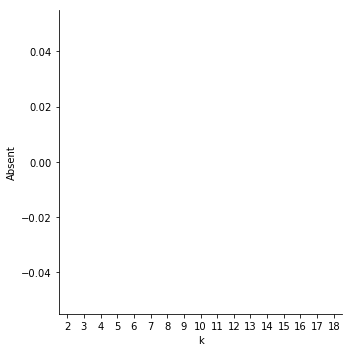

In [6]:
import numpy as np
from brain_states.measures import absent_states
import seaborn as sns
%matplotlib inline

# Check if there are any missing brain states in the data
absent_states = absent_states(sub_ses_bs_dualnback)
absent_states.head()

sns.catplot(x='k', y='Absent', data=absent_states, kind = 'bar')

Step 6: Correlating cluster labels with well-known large-scale networks
-------------------------------------------------------------------------

To describe the pattern of brain dynamics characteristic for each brain state, we averaged timeseries across each cluster and calculated Pearson's correlation of resulting 400-element vector (mean activity within each parcel from Schaefer parcellation) with binary vectors representing *a priori* defined 7-network partition (Schaefer, et al. 2018).

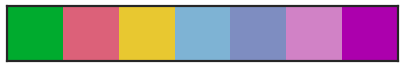

In [70]:
from brain_states.figures import get_pallette_schaefer400, get_seaborn_slyle

get_seaborn_slyle()
networks, network_pal = get_pallette_schaefer400()

In [71]:
import pandas as pd

states_no = 6
k_brain_states = brain_states[states_no-2]

# Creating data frame with dummy codes for each brain state
brain_states_filter = pd.get_dummies(k_brain_states)
brain_states_filter.columns = np.arange(1,states_no+1)

# Getting mean brain states timeseries
mean_brain_states = np.zeros((states_no,400))
for i, col in enumerate(brain_states_filter):
    state_filter = brain_states_filter[col].values.astype(bool)
    mean_brain_states[i] = cts_all[state_filter].mean(axis=0)
    
mean_brain_states.shape

(6, 400)

AttributeError: 'numpy.ndarray' object has no attribute 'tick_params'

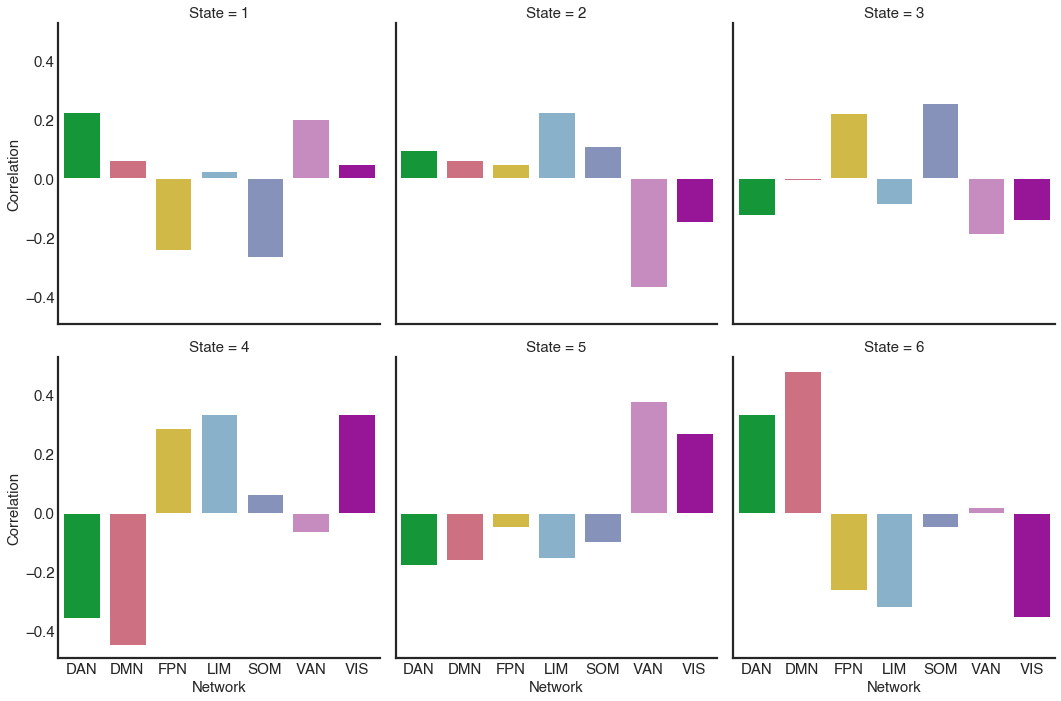

In [147]:
# Creating data frame with dummy codes for each network
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt

networks_binary = pd.get_dummies(networks)
networks_correlations = pd.DataFrame()


for k in range(states_no):
    for j, net in enumerate(networks_binary.columns):
        correlation = pearsonr(mean_brain_states[k], (networks_binary.iloc[:,j].values))[0]
        similatity_pos = cosine(mean_brain_states[k].clip(min=0), (networks_binary.iloc[:,j].values))
        similatity_neg = cosine(mean_brain_states[k].clip(max=0), (networks_binary.iloc[:,j].values))
        networks_correlations = pd.concat([networks_correlations, pd.DataFrame({"State":k+1, 
                                                                                "Network": net, 
                                                                                "Correlation": correlation,
                                                                                "Similarity_pos": similatity_pos,
                                                                                "Similarity_neg": similatity_neg
                                                                               },
                                                                               index=[0])], 
                                          axis=0)
        
p = sns.catplot(x='Network', y='Correlation', col='State', kind='bar', col_wrap=3, data=networks_correlations, palette=network_pal)

/home/finc/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:1752: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


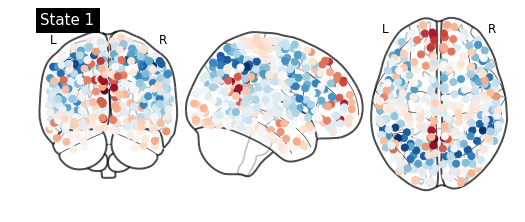

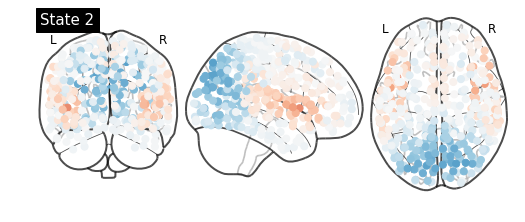

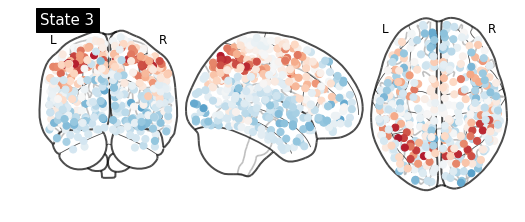

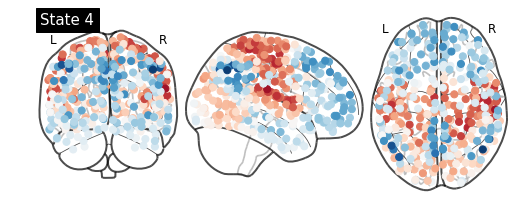

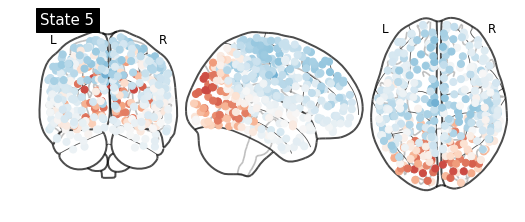

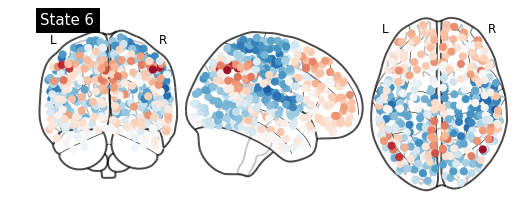

In [11]:
from nilearn import plotting

schaefer_coord = pd.read_csv("Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.Centroid_RAS.csv")
schaefer_coord = np.stack((schaefer_coord.iloc[1:, 2], schaefer_coord.iloc[1:, 3], schaefer_coord.iloc[1:, 4])).T

norm = plt.Normalize(vmin=mean_brain_states.min(), vmax=mean_brain_states.max())

for i in range(6):
    colors = plt.cm.RdBu_r(norm(mean_brain_states[i]))
    plotting.plot_connectome(np.zeros((400,400)), schaefer_coord, node_color=colors, title=f"State {i+1}", colorbar)

/home/finc/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


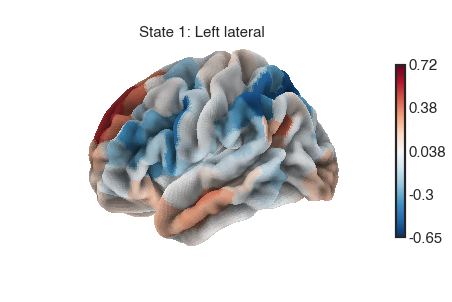

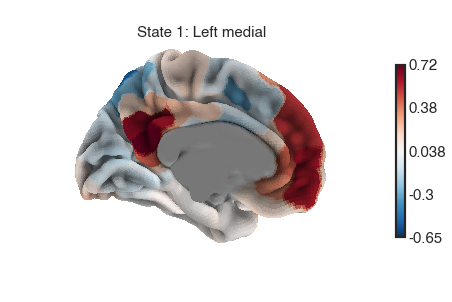

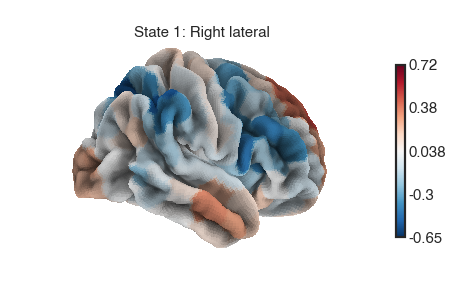

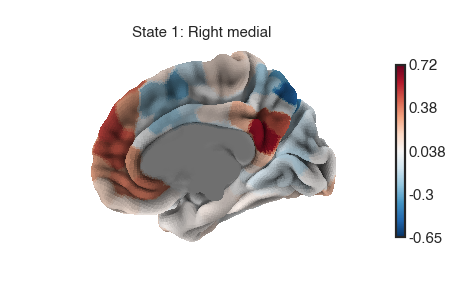

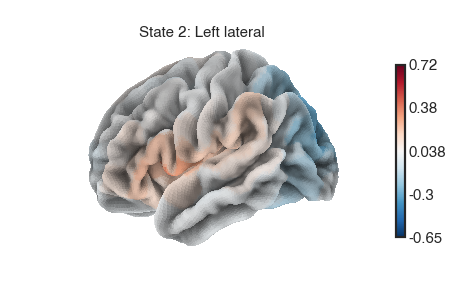

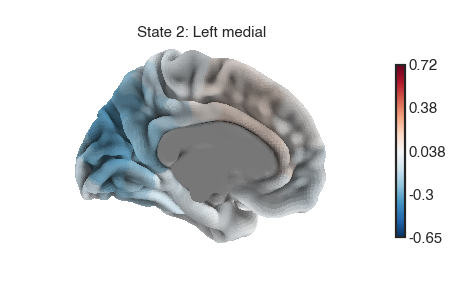

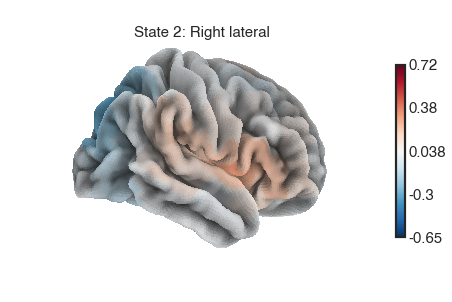

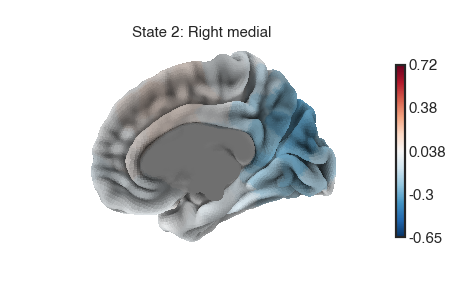

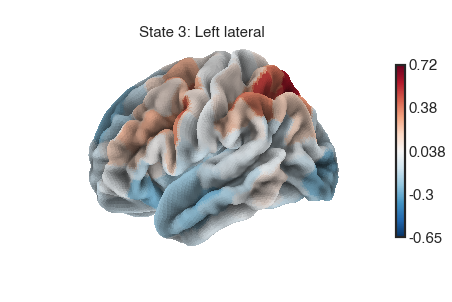

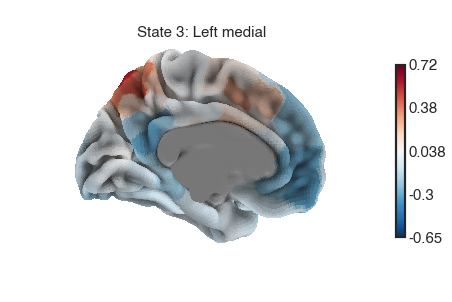

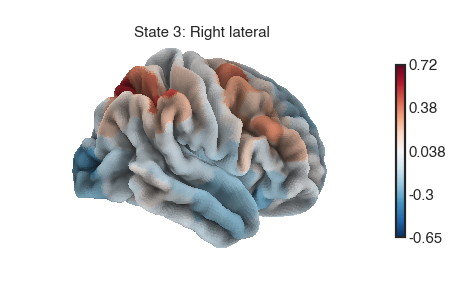

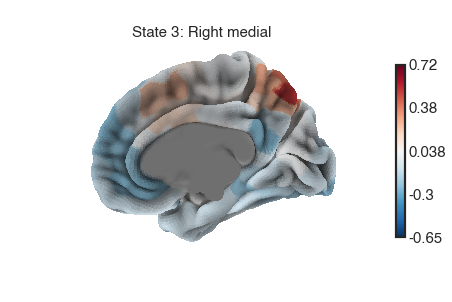

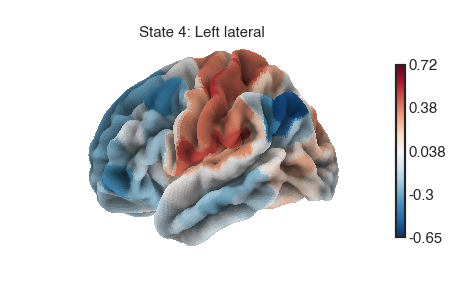

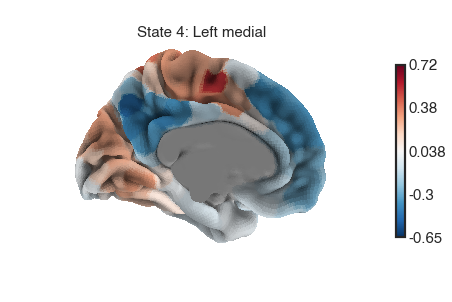

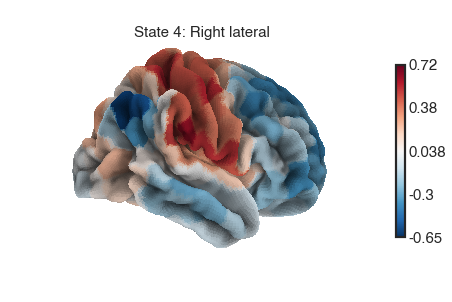

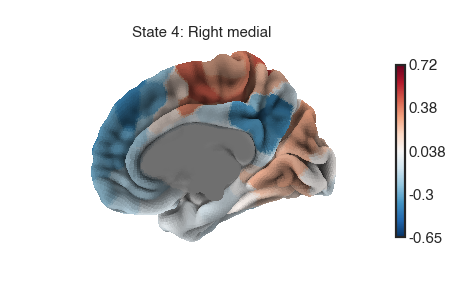

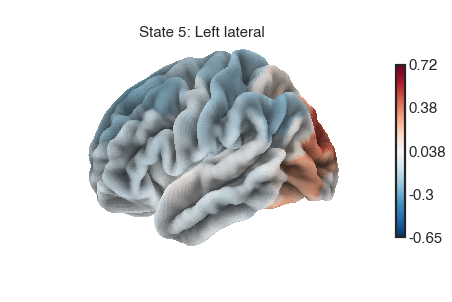

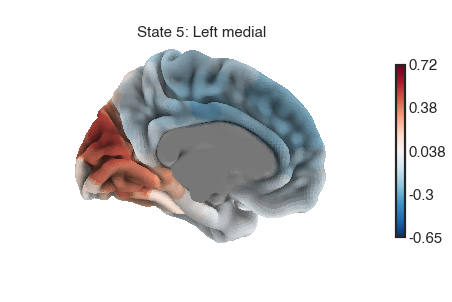

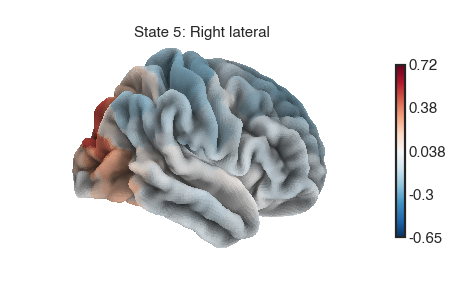

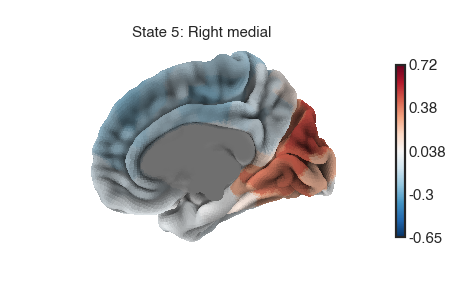

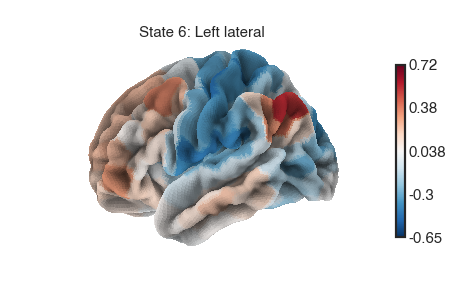

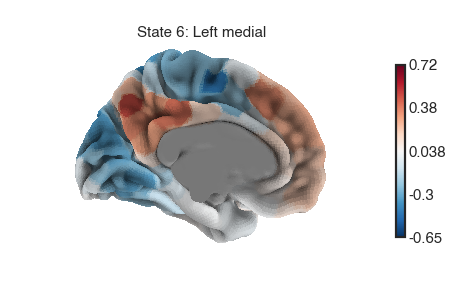

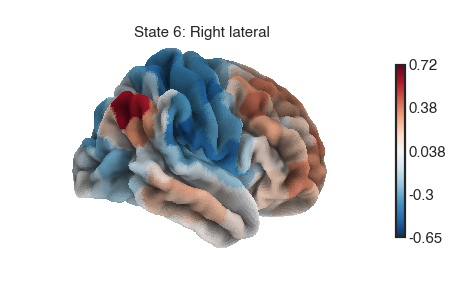

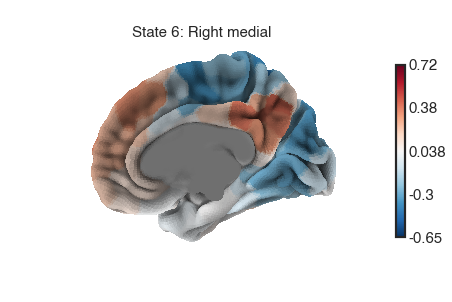

In [15]:
from brain_states import figures

vmin = np.min(mean_brain_states)
vmax = np.max(mean_brain_states)

for i in range(6):
    figures.surface_plots_schaefer400(mean_brain_states[i], vmin=vmin, vmax=vmax, title=f"State {i+1}: ")

Step 5: Calculating brain states measures for each subject/session
-------------------------------------------------------------------------

We calculated several measures using brain states labels, to to better describe brain states dynamics. 
For each subject, session, and task we calculated state's: 

- **fractional occupancy** - percentage of timepoints in each run classified as a particular state
- **dwell times** - the mean length of consecutives timepoints classified as a particular state
- **persistence probability** - probability of the remaining in the same state. Diagonal elements of $P_{ij}$.
- **transition probability** - probability of the transition from state $i$ to state $j$ given the current state $i$ divided by the sum of occurencies of $i$, resulting in $S\times S$ probability matrix $P_{ij}$, where S is equal to number of examined states.
- **transitions probabilities ver 2** (after removing dwelling in states)

In [22]:
import pandas as pd
from brain_states import dwell_time

# First we calculted frational occupancy and dwell times were calculated
states_no = 6

tasks = {'dualnback': sub_ses_bs_dualnback[states_no-2, :, :, :], 'rest': sub_ses_bs_rest[states_no-2, :, :, :]}
bs_measures = pd.DataFrame()

for task, bs in tasks.items():
    for sub in range(bs.shape[0]):
        subject = groups_clean.iloc[sub]['sub']
        for ses in range(bs.shape[1]):
            session = f"ses-{ses+1}"
            vector = bs[sub, ses,:]
            frac_occ = (np.unique(vector, return_counts=True)[1]/bs.shape[2])*100 # fractonal occupancy
            for state in range(states_no):
                bs_measures = pd.concat([bs_measures, pd.DataFrame({"Subject": subject,
                                                                    "Group": groups_clean.iloc[sub]['group'],
                                                                    "Session": session,
                                                                    "Task": task,
                                                                    "State": state+1,
                                                                    "Fractional_occupancy": frac_occ[state],
                                                                    "Dwell_time": dwell_time(vector, state)*2 # Dwell time
                                                                   }, 
                                                                    index=[0])], 
                                              axis=0)


Plotting
============

1) Dwell time:
------------

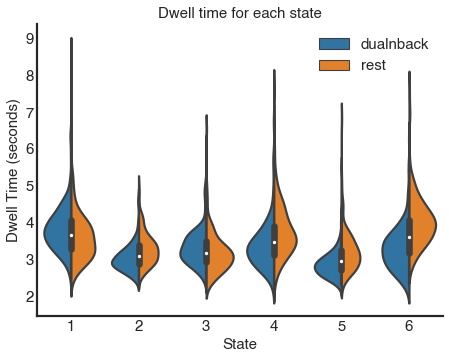

In [24]:
sns.catplot(x="State", 
            y="Dwell_time", 
            hue="Task", 
            data=bs_measures, 
            kind="violin",
            #kind="box",
            #ax=ax, 
            height=5, aspect=1.3,
            legend=False,
            split=True
           ).set(xlabel="State",
                            ylabel="Dwell Time (seconds)")
plt.title("Dwell time for each state")
plt.legend(loc='best')

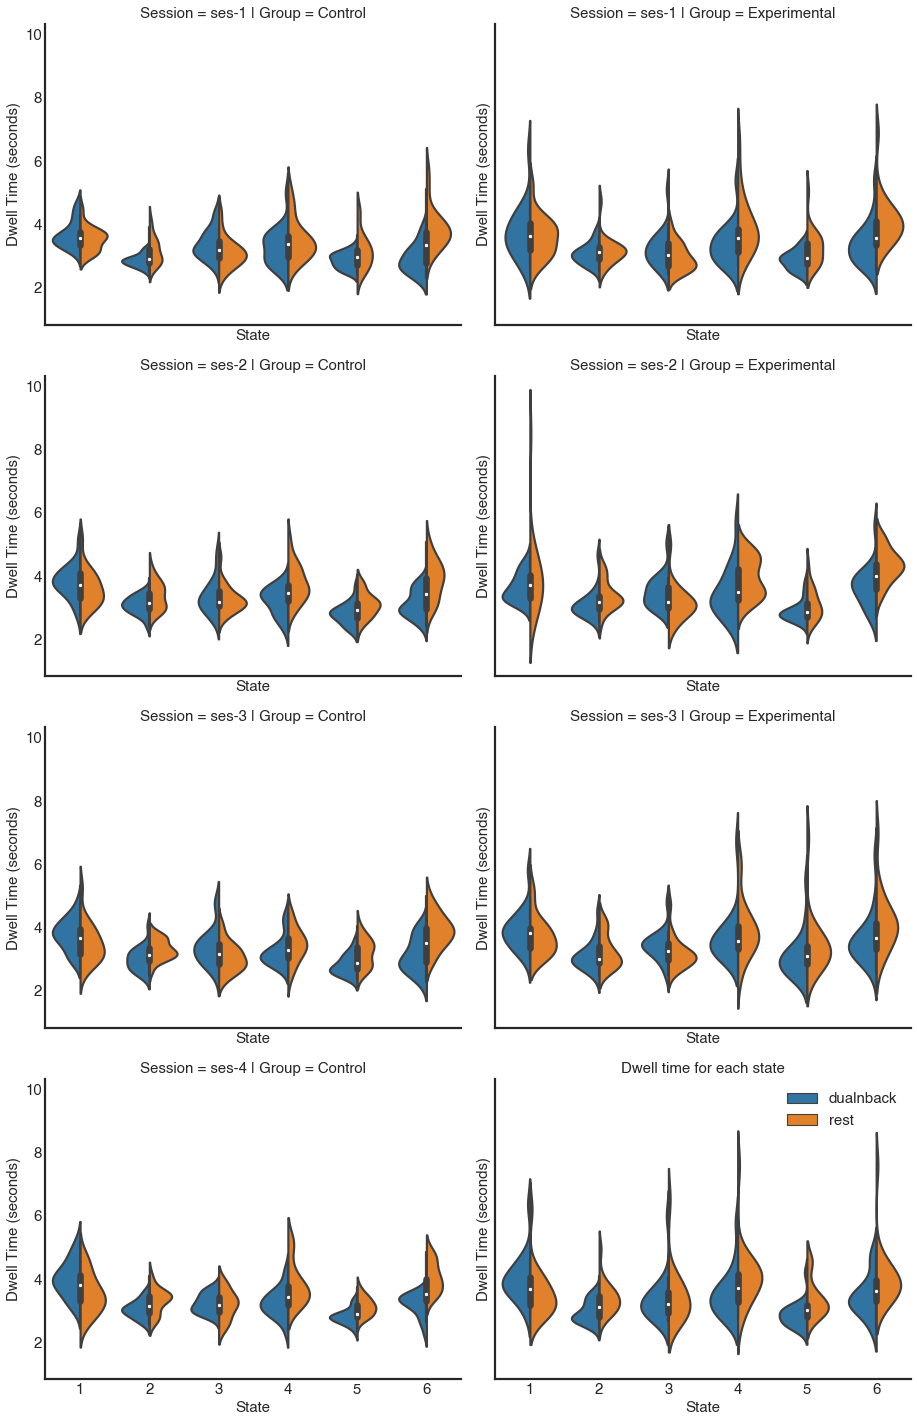

In [25]:
sns.catplot(x="State", 
            y="Dwell_time", 
            hue="Task", 
            data = bs_measures, 
            row='Session', col='Group',
            kind = "violin",
            #ax=ax, 
            height=5, aspect=1.3,
            legend=False,
            split=True).set(xlabel="State",
                           ylabel="Dwell Time (seconds)")
plt.title("Dwell time for each state")
plt.legend(loc='best')
plt.tight_layout()

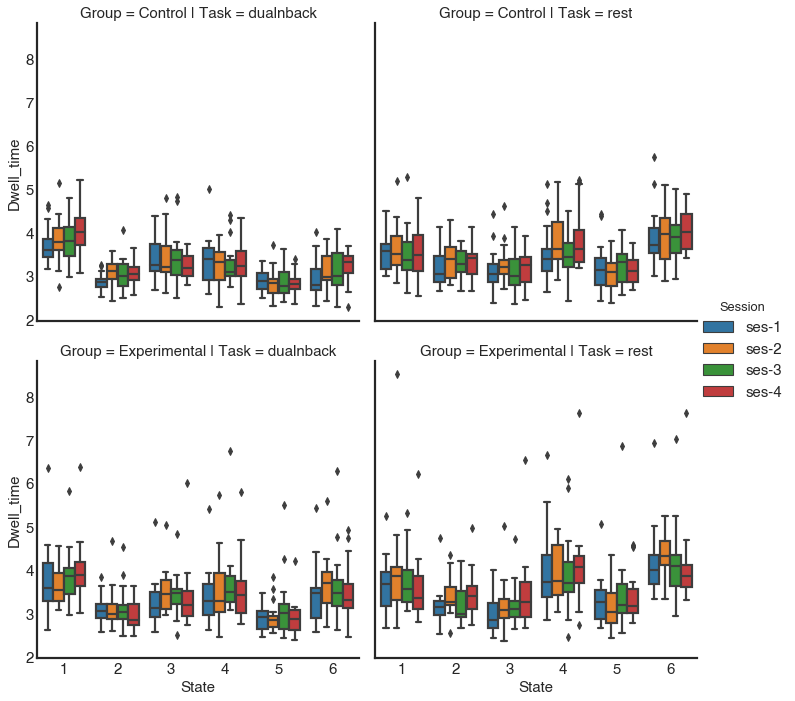

In [26]:
sns.catplot(x='State', y='Dwell_time', hue='Session', col='Task', row='Group', data = bs_measures, kind = 'box')

2) Fractional occupancy:
---------------------------------

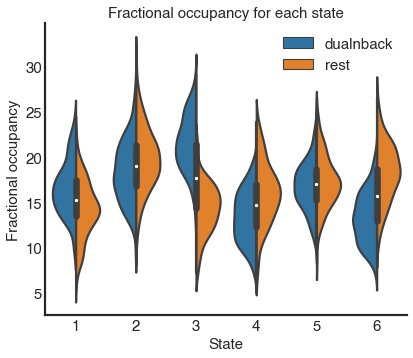

In [27]:
sns.catplot(x="State", 
            y="Fractional_occupancy", 
            hue="Task", 
            data = bs_measures, 
            kind = "violin",
            height=5, aspect=1.2,
            legend=False,
            split=True).set(xlabel="State",
                            ylabel="Fractional occupancy")
plt.title("Fractional occupancy for each state")
plt.legend(loc='best')

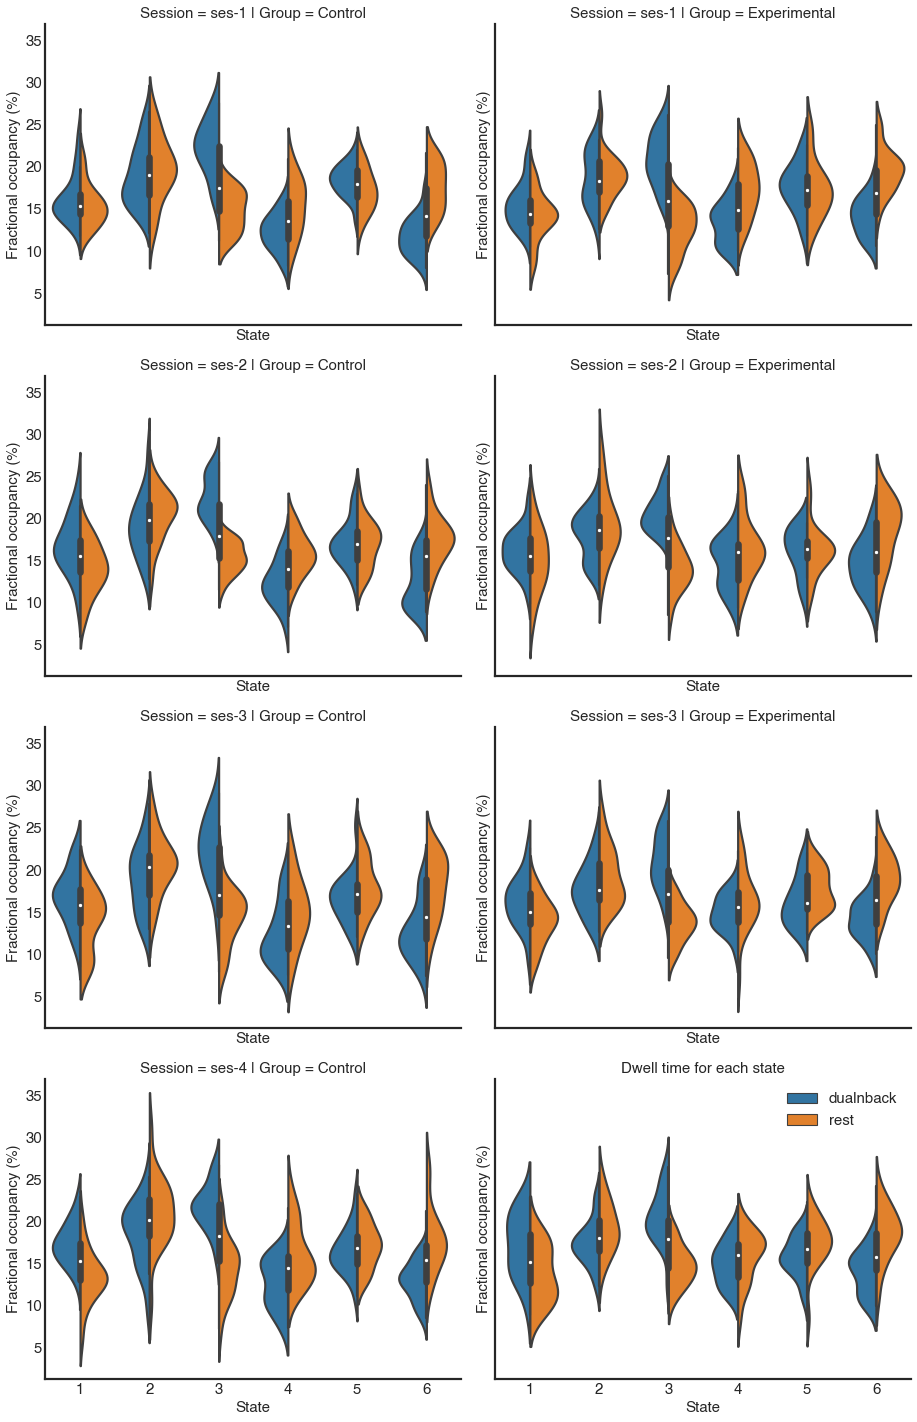

In [28]:
sns.catplot(x="State", 
            y="Fractional_occupancy", 
            hue="Task", 
            data = bs_measures, 
            row='Session', col='Group',
            kind = "violin",
            #ax=ax, 
            height=5, aspect=1.3,
            legend=False,
            split=True).set(xlabel="State",
                            ylabel="Fractional occupancy (%)")
plt.title("Dwell time for each state")
plt.legend(loc='best')
plt.tight_layout()

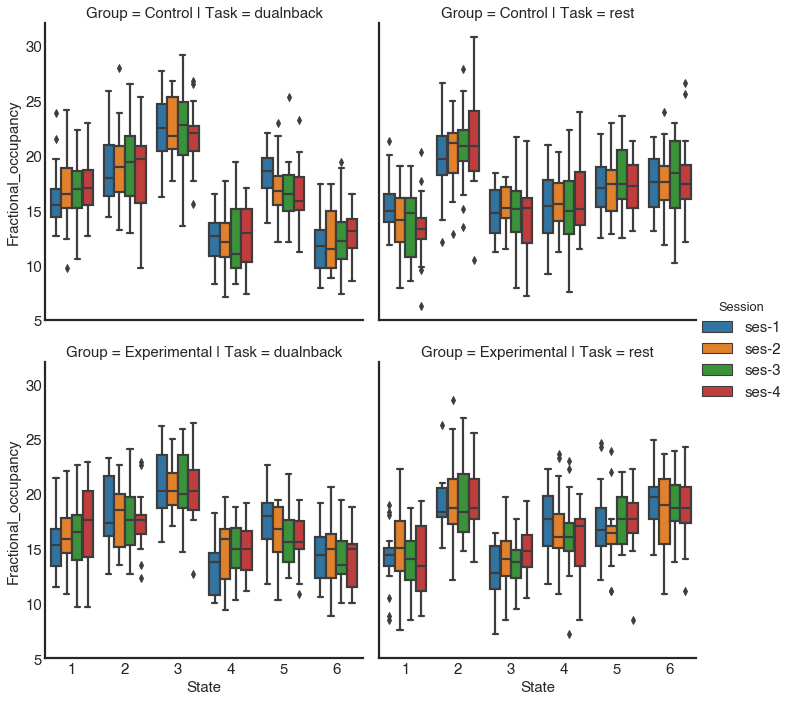

In [29]:
sns.catplot(x='State', y='Fractional_occupancy', hue='Session', col='Task', row='Group', data = bs_measures, kind = 'box')

3-4) Persistence and transition probabilities
----------------------------------------------

In [160]:
from nilearn import plotting
from nilearn.plotting import plot_matrix

bs_all = [sub_ses_bs_dualnback[states_no-2, :, :, :], 
          sub_ses_bs_rest[states_no-2, :, :, :]]

state_transitions = np.zeros((sub_ses_bs_dualnback.shape[1], 
                              sub_ses_bs_dualnback.shape[2], 
                              2, states_no, states_no))

# calculating persistence and transition probabilities
for s, bs in enumerate(bs_all):
    for sub in range(bs.shape[0]):
        for ses in range(bs.shape[1]):    
            for i in range(states_no):
                for j in range(states_no):
                    count = 0
                    for l in range(bs.shape[2]-1):
                        if bs[sub, ses,l]==i and bs[sub, ses, l+1]==j:
                            count += 1
                            p = count/np.unique(bs[sub,ses,:], return_counts=True)[1][i]
                    state_transitions[sub, ses, s, i, j] = p

state_transitions.shape

(39, 4, 2, 6, 6)

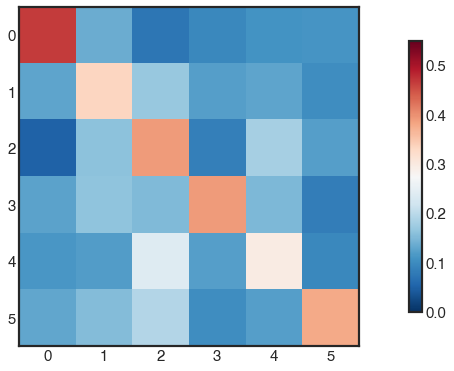

In [96]:
# Dualnback transition matrix
plot_matrix(state_transitions[:,:,0,:,:].mean(axis=0).mean(axis=0), vmin=0, vmax=0.55)

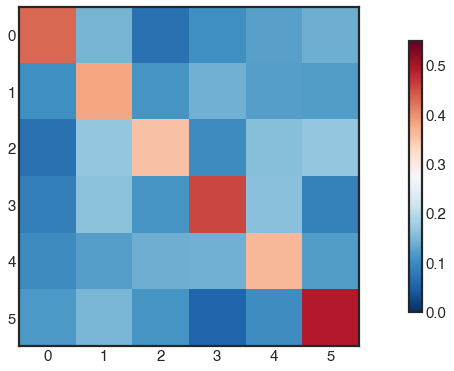

In [97]:
# Rest transition matrix
plot_matrix(state_transitions[:,:,1,:,:].mean(axis=0).mean(axis=0), vmin=0, vmax=0.55)

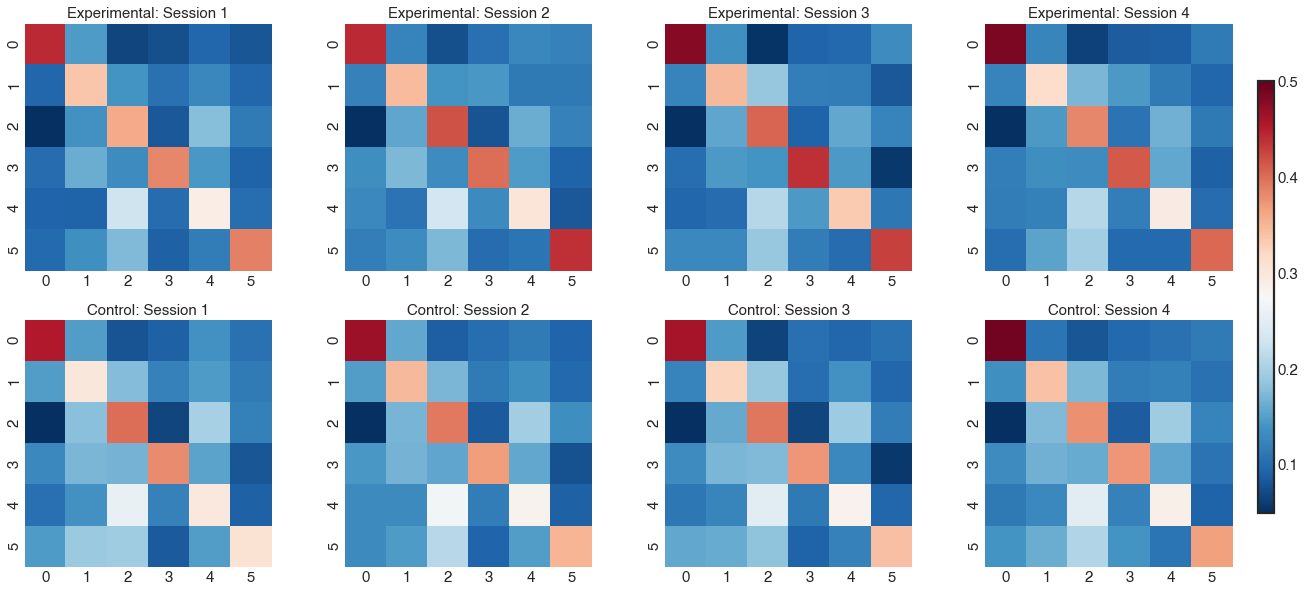

In [162]:
groups = {'Experimental': np.asarray(groups_clean['group'] == 'Experimental'), 'Control': np.asarray(groups_clean['group'] == 'Control')}

#fig, ax = plt.subplots(2,4)

fig, axes = plt.subplots(2, 4)
fig.set_size_inches(22, 10)

for i, group in enumerate(groups.items()):
    for j in range(state_transitions.shape[1]):
        #plt.imshow(state_transitions_only[group[1],j,0,:,:].mean(axis=0), vmax=0.07)
        
        g = sns.heatmap(state_transitions[group[1],j,0,:,:].mean(axis=0), 
                        vmax=0.5,
                        square = True, 
                        cmap = "RdBu_r", 
                        ax=axes[i][j],
                        #vmin = 0.25, vmax = 0.45,
                        cbar=None)
        g.set_title(f'{group[0]}: Session {j+1}', size = 15)
        im = plt.gca().get_children()[0]
cax = fig.add_axes([.91, .2, .01, .6]) 
fig.colorbar(im, cax=cax, drawedges = False)

5) Calculating transitions probabilities (ignoring persistence)
----------------------------------------------

In [98]:
from brain_states.measures import remove_repetitions
from nilearn import plotting
from nilearn.plotting import plot_matrix

state_transitions_only = np.zeros((sub_ses_bs_dualnback.shape[1], 
                                   sub_ses_bs_dualnback.shape[2], 
                                   2, 
                                   states_no, 
                                   states_no))
for s, bs in enumerate(bs_all):
    for sub in range(bs.shape[0]):
        for ses in range(bs.shape[1]):
            bs_reduced = remove_repetitions(bs[sub,ses,:])
            for i in range(states_no):
                for j in range(states_no):
                    count_match = 0
                    count_notmatch = 0

                    for l in range(len(bs_reduced)-1):
                        if bs_reduced[l]==i and bs_reduced[l+1]==j:
                            count_match += 1
                        else:
                            count_notmatch += 1

                    state_transitions_only[sub, ses, s, i, j] = count_match/(count_match+count_notmatch)


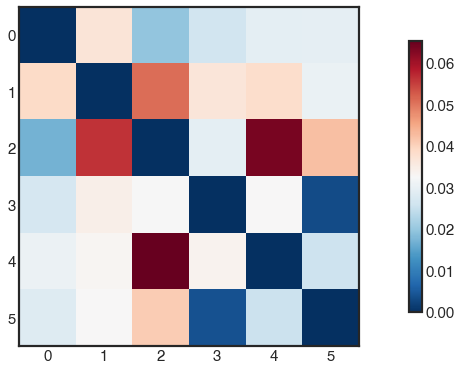

In [99]:
# Dualnback transition matrix
plot_matrix(state_transitions_only[:,:,0,:,:].mean(axis=0).mean(axis=0))

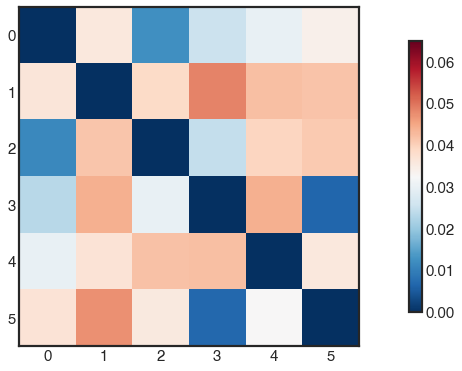

In [182]:
#Rest transition matrix
plot_matrix(state_transitions_only[:,:,1,:,:].mean(axis=0).mean(axis=0), vmax=0.065)

Comparing transitions between task and nback
===============================================

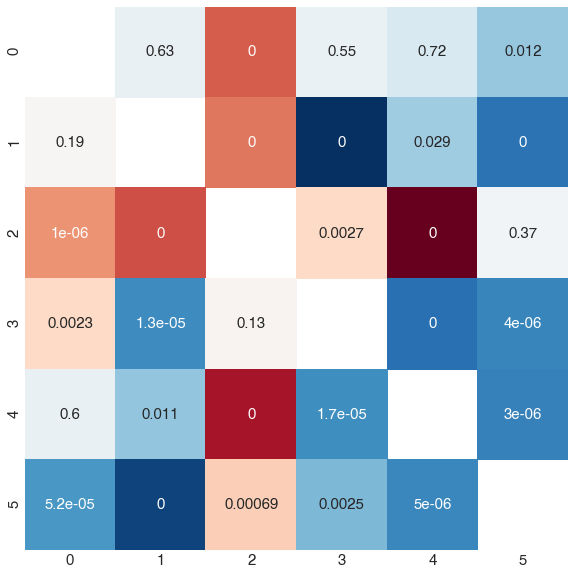

In [181]:
from scipy.stats import ttest_rel

mm_stat = np.zeros((6,6))
mm_pval = np.zeros((6,6))

from scipy.stats import ttest_rel

for i in range(6):
    for j in range(6):
        stat, pval = ttest_rel(state_transitions_only[:,:,0,i,j].mean(axis=1), 
                            state_transitions_only[:,:,1,i,j].mean(axis=1))
        
        mm_stat[i,j] = stat 
        mm_pval[i,j] = round(pval, 6)

plt.figure(figsize=(20,10))
g = sns.heatmap(mm_stat, 
                #yticklabels = np.unique(modules), 
                #xticklabels = np.unique(modules), 
                square = True, 
                cmap = "RdBu_r", 
                #ax=axes[i],
                #vmin = -8, vmax = 8,
                cbar=None,#,
                annot = mm_pval[:, :])

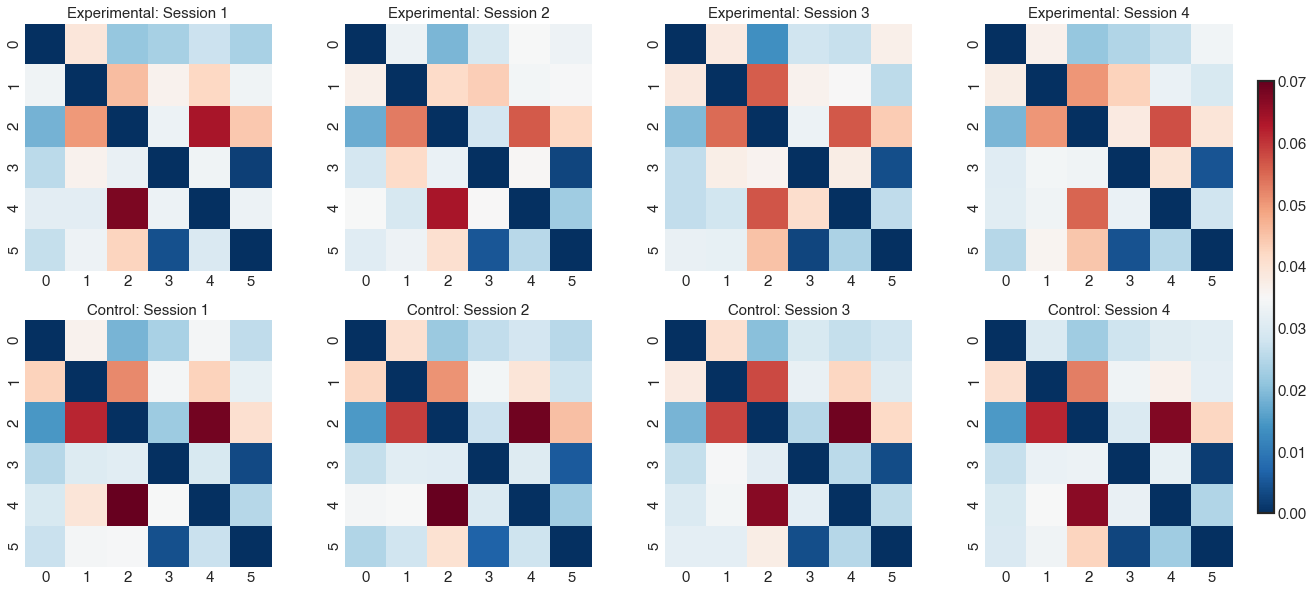

In [158]:
groups = {'Experimental': np.asarray(groups_clean['group'] == 'Experimental'), 'Control': np.asarray(groups_clean['group'] == 'Control')}

#fig, ax = plt.subplots(2,4)

fig, axes = plt.subplots(2, 4)
fig.set_size_inches(22, 10)

for i, group in enumerate(groups.items()):
    for j in range(state_transitions_only.shape[1]):
        #plt.imshow(state_transitions_only[group[1],j,0,:,:].mean(axis=0), vmax=0.07)
        
        g = sns.heatmap(state_transitions_only[group[1],j,0,:,:].mean(axis=0), 
                        vmax=0.07,
                        square = True, 
                        cmap = "RdBu_r", 
                        ax=axes[i][j],
                        #vmin = 0.25, vmax = 0.45,
                        cbar=None)
        g.set_title(f'{group[0]}: Session {j+1}', size = 15)
        im = plt.gca().get_children()[0]
cax = fig.add_axes([.91, .2, .01, .6]) 
fig.colorbar(im, cax=cax, drawedges = False)

Step 6: Groups/sessions comparison
-------------------------------------------------------------------------
Description

In [37]:
# Code here